In [1]:
#from src import load
#from src.load import read_data
import load
from load import read_data
import numpy as np
import pandas as pd
import pickle
# from src.kir_transformers import cv
from kir_transformers import cv

# from src.kir_models import lr
# from src.kir_transformers import tfidf_new
# from src.kir_models import metrics
# from src.kir_models import featureEngineering

from kir_models import lr
from kir_transformers import tfidf_new
from kir_models import metrics
from kir_models import featureEngineering

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [2]:
# loaded load.py
train_X, val_X, train_y, val_y = read_data()

In [3]:
# fill up empty reviews
train_X['review'].fillna('', inplace=True)
val_X['review'].fillna('', inplace=True)

In [4]:
# loading kir_transformers.py for count vectorizer
# using only the review column for now 
params = {'max_features': 1000}
vectorizer = cv(train_X['review'], params)

# loading kir_transformers.py for tfidf vectorizer
params_tf = {'max_features': 1000}
vectorizer_tf = tfidf_new(train_X['review'], params_tf)

In [5]:
# transforming both train and val

# CV
train_vec = vectorizer.transform(train_X['review'])
val_vec = vectorizer.transform(val_X['review'])

# TFIDF
train_vec_tf = vectorizer_tf.transform(train_X['review'])
val_vec_tf = vectorizer_tf.transform(val_X['review'])

In [6]:
# Sparse matrices

#CV
train_vec_df = pd.DataFrame.sparse.from_spmatrix(train_vec)
val_vec_df = pd.DataFrame.sparse.from_spmatrix(val_vec)

#TFIDF
train_vec_df_tf = pd.DataFrame.sparse.from_spmatrix(train_vec_tf)
val_vec_df_tf = pd.DataFrame.sparse.from_spmatrix(val_vec_tf)

In [7]:
# pass through the new function defined by Stephen and drop columns that can't be fed to the LR model
train_X_new, fake_users = featureEngineering(train_X, train_y)
val_X_new, fake_users = featureEngineering(val_X, val_y, fake_users)

val_X_new.drop(['date', 'user_id', 'rating'], inplace=True, axis =1)
train_X_new.drop(['date', 'user_id', 'rating'], inplace=True, axis =1)


In [8]:
# addition of columns for Stephen's function
train_vec_df['rating_indicator'] = train_X_new['rating_indicator']
train_vec_df_tf['rating_indicator'] = train_X_new['rating_indicator']
val_vec_df['rating_indicator'] = val_X_new['rating_indicator']
val_vec_df_tf['rating_indicator'] = val_X_new['rating_indicator']

train_vec_df['previous_fake'] = train_X_new['previous_fake']
train_vec_df_tf['previous_fake'] = train_X_new['previous_fake']
val_vec_df['previous_fake'] = val_X_new['previous_fake']
val_vec_df_tf['previous_fake'] = val_X_new['previous_fake']

train_vec_df['reviews_today'] = train_X_new['reviews_today']
train_vec_df_tf['reviews_today'] = train_X_new['reviews_today']
val_vec_df['reviews_today'] = val_X_new['reviews_today']
val_vec_df_tf['reviews_today'] = val_X_new['reviews_today']

In [9]:

# fit the best hyperparameter configuration to LR - CV
p_best = {'C':100, 'penalty': 'l2', 'verbose':10, 'solver':'liblinear'}
model = lr(p_best)
model.fit(train_vec_df, train_y['label'])

[LibLinear]

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=10, warm_start=False)

In [10]:
# fit the best hyperparameter configuration to LR - TFIDF
p_best_tf = {'C':0.1, 'penalty': 'l2', 'verbose':10, 'solver':'liblinear'}
model_tf = lr(p_best_tf)
model_tf.fit(train_vec_df_tf, train_y['label'])

[LibLinear]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001,
                   verbose=10, warm_start=False)

Predicted      0     1    All
True                         
0          32014  2527  34541
1            256  1121   1377
All        32270  3648  35918


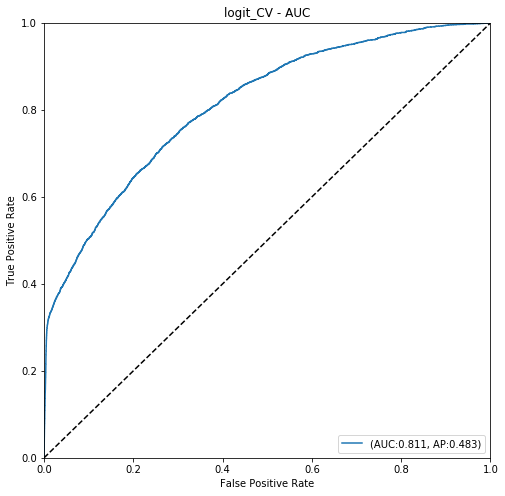

In [11]:
# hyperparameter tuning - no oversampling - CV
metrics(model, val_vec_df, val_y['label'], 'logit_CV')

Predicted      0     1    All
True                         
0          32025  2524  34549
1            245  1124   1369
All        32270  3648  35918


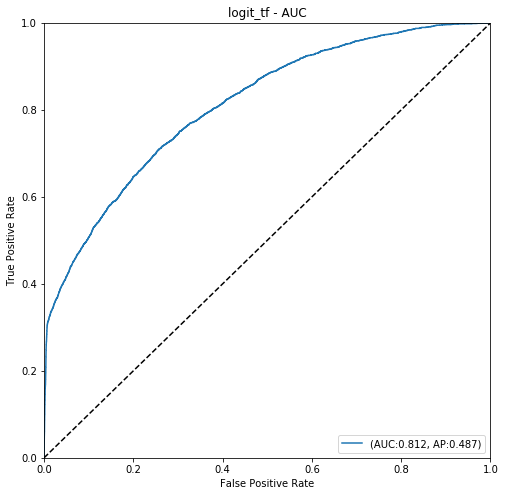

In [12]:
# using oversampling - CV
metrics(model_tf, val_vec_df_tf, val_y['label'], 'logit_tf')